In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
def quantify_correlation(base_dir, suite_names, r_target=0.01, x_var="cvir", slope_var="slope_Q_r"):
    """ 
    Quantify the correlation between PPSD slope and halo properties: concentration or accretion rate at target radius.
    """
    slope_vals, x_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(df_cvir["halo_id"], df_cvir["cvir"]))
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))
        mass_dict = dict(zip(pd.read_csv(mass_path)["halo_id"], pd.read_csv(mass_path)["mvir"]))

        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med = np.nanmedian(c_vals)
            c_std = np.nanstd(c_vals)
            delta_c_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            valid_gamma = df_gamma["gamma"].values
            valid_mask = (valid_gamma > 0) & np.isfinite(valid_gamma)
            log_g_vals = np.log10(valid_gamma[valid_mask])

            log_g_med = np.nanmedian(log_g_vals)
            log_g_std = np.nanstd(log_g_vals)

            delta_g_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - log_g_med) / log_g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        for f in sorted([f for f in os.listdir(slope_r_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(slope_r_dir, f))
                r = df["r_scaled"].values
                slope = df[slope_var].values
                interp_func = interp1d(r, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_func(r_target))

                if x_var == "cvir":
                    x = cvir_dict.get(halo_id)
                elif x_var == "gamma":
                    x = gamma_dict.get(halo_id)
                elif x_var == "delta_c_norm":
                    x = delta_c_dict.get(halo_id)
                elif x_var == "delta_gamma_norm":
                    x = delta_g_dict.get(halo_id)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(halo_id, np.nan)
                try:
                    slope_val = float(interp_func(r_target))
                    x = float(x) 
                    mass = float(mass)
                except Exception as e:
                    continue
                if np.isfinite(slope_val) and np.isfinite(x) and (x_var != "gamma" or x > 0):
                    slope_vals.append(slope_val)
                    x_vals.append(x)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    slope_vals = np.array(slope_vals)
    x_vals = np.array(x_vals)
    mass_vals = np.array(mass_vals)

    if len(slope_vals) < 2:
        print("[Warning] Not enough valid data to compute correlation.")
        return

    log_mass = np.log10(mass_vals)
    log_x = np.log10(x_vals) if x_var == "gamma" else x_vals

    spearman_r, spearman_p = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors='none')
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")

    xlabel_map = {
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c}) / \sigma_c$",
        "delta_gamma_norm": r"$(\gamma - \tilde{\gamma}) / \sigma_\gamma$"
    }
    plt.xlabel(xlabel_map.get(x_var, x_var))
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Correlation at $r = {r_target} R_{{\\rm vir}}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_gamma_norm",
    slope_var="slope_Q_r"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_c_norm",
    slope_var="slope_Q_r"
)

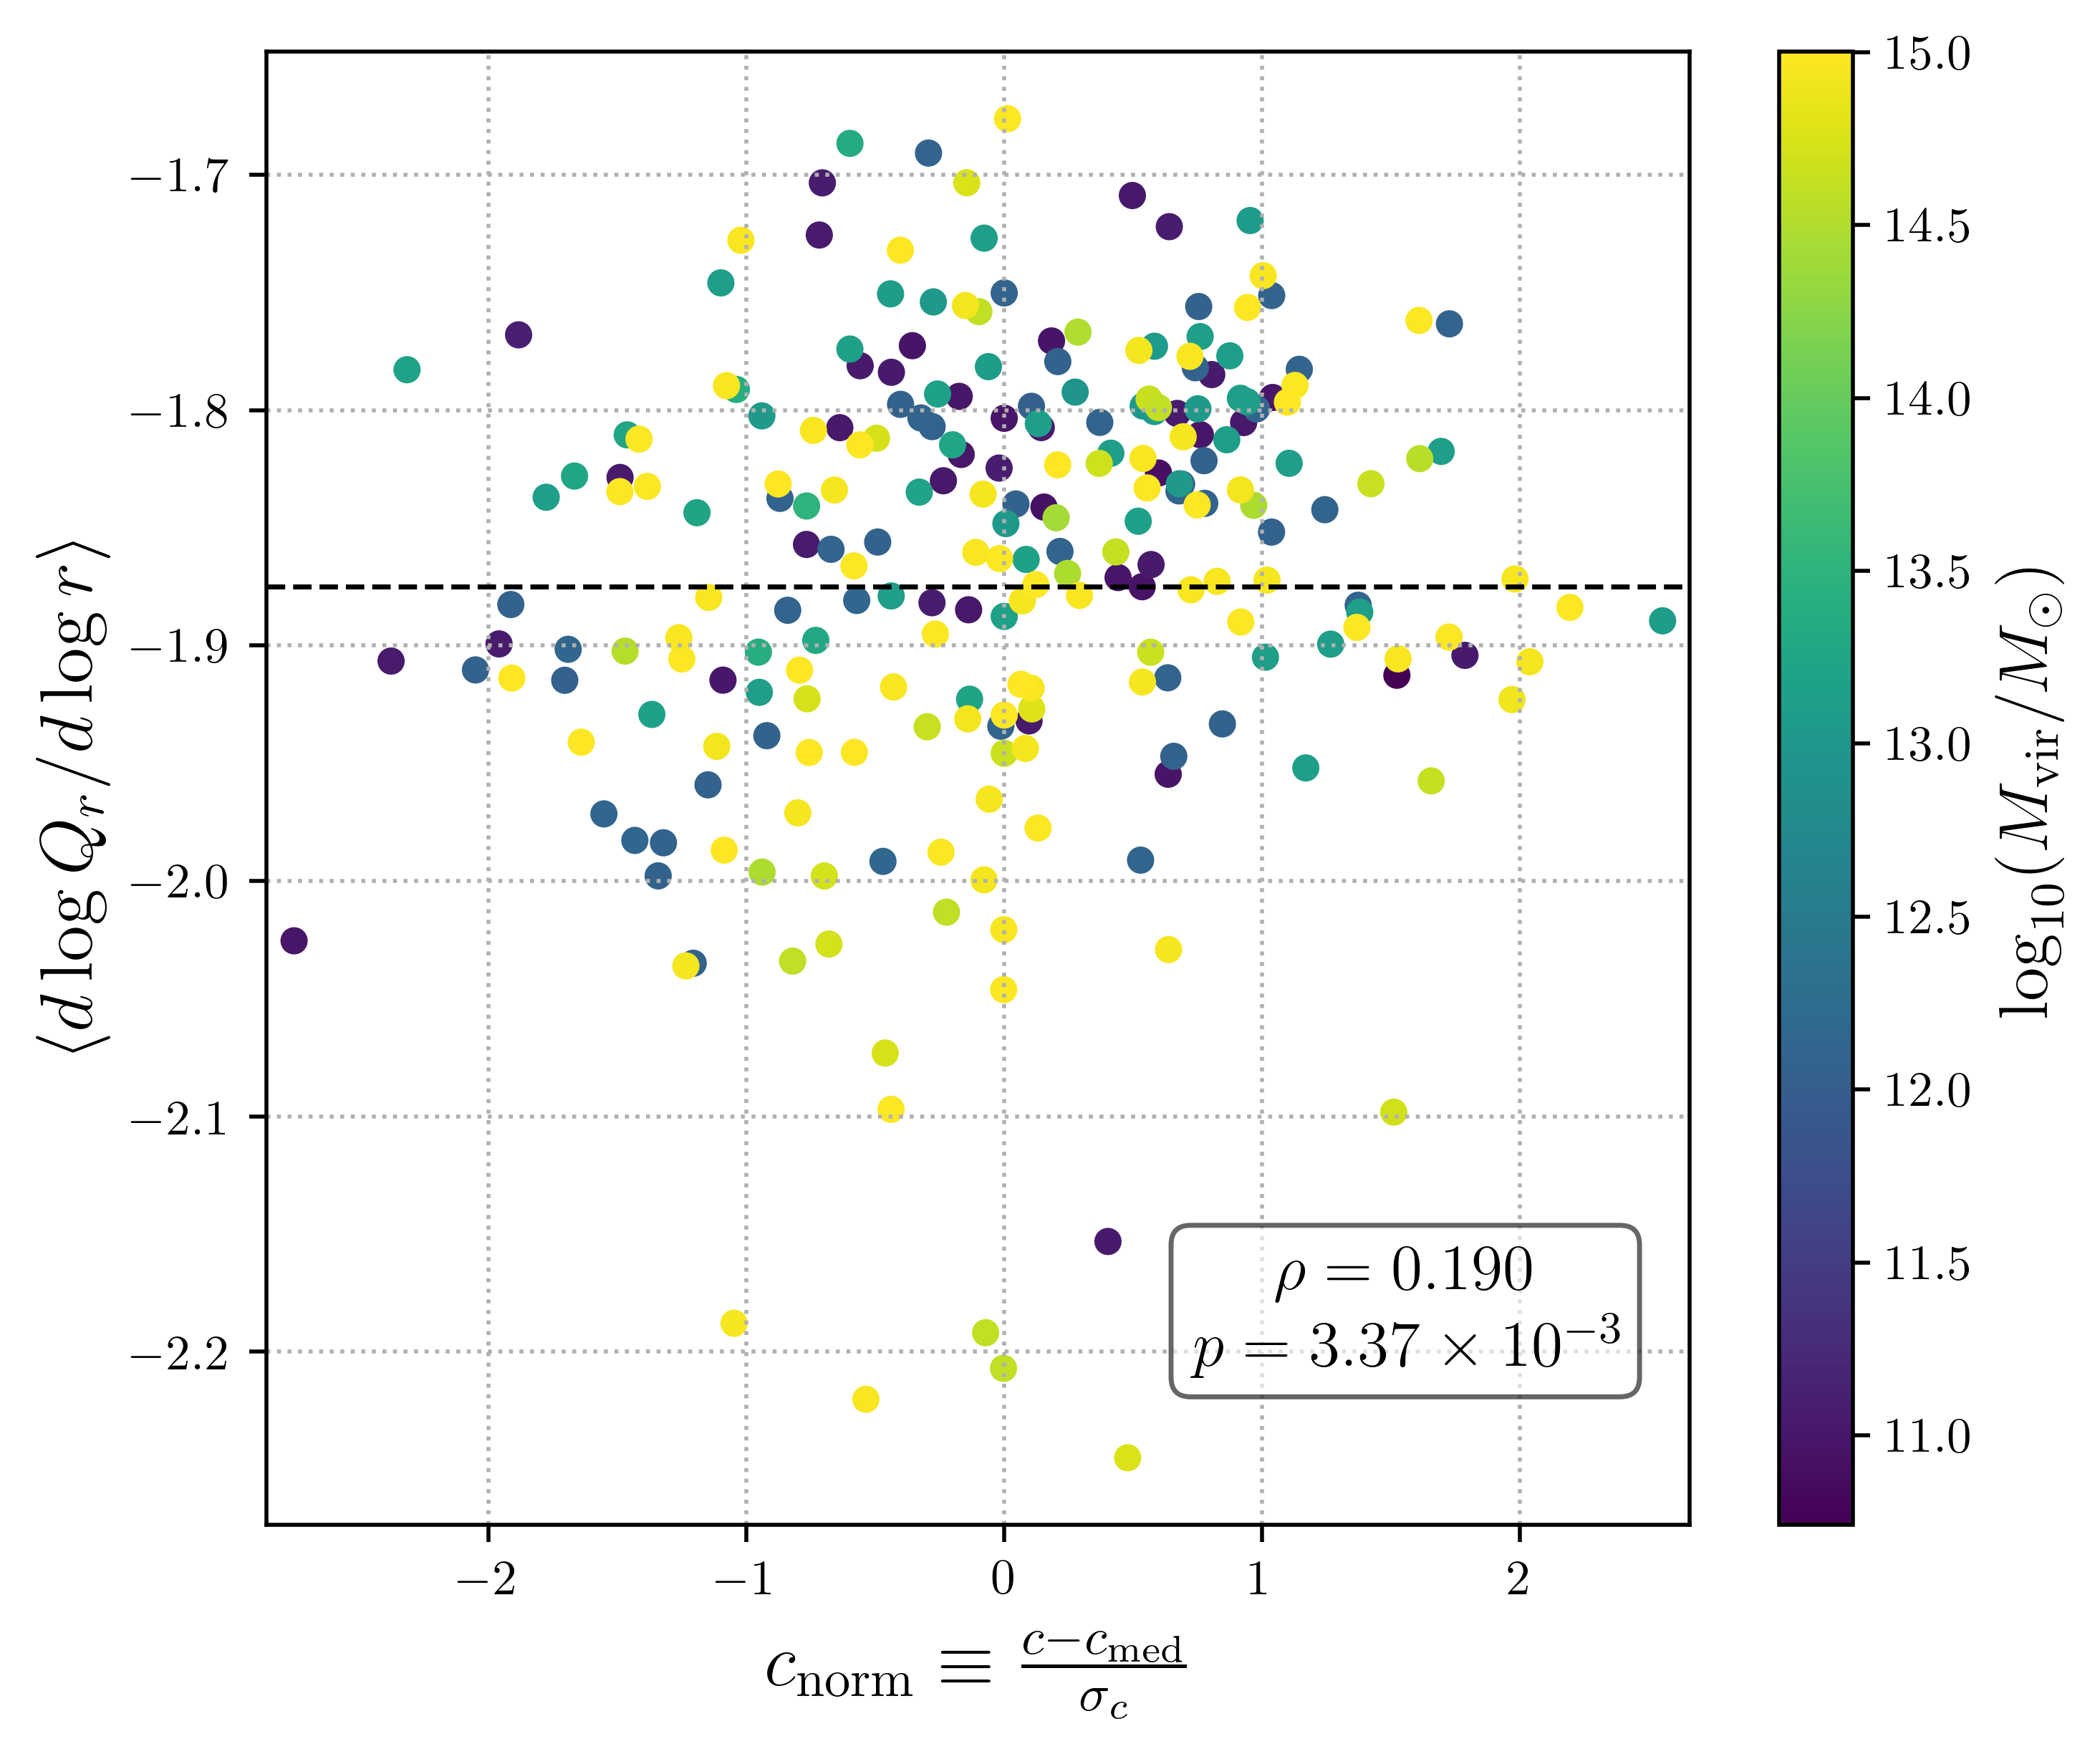

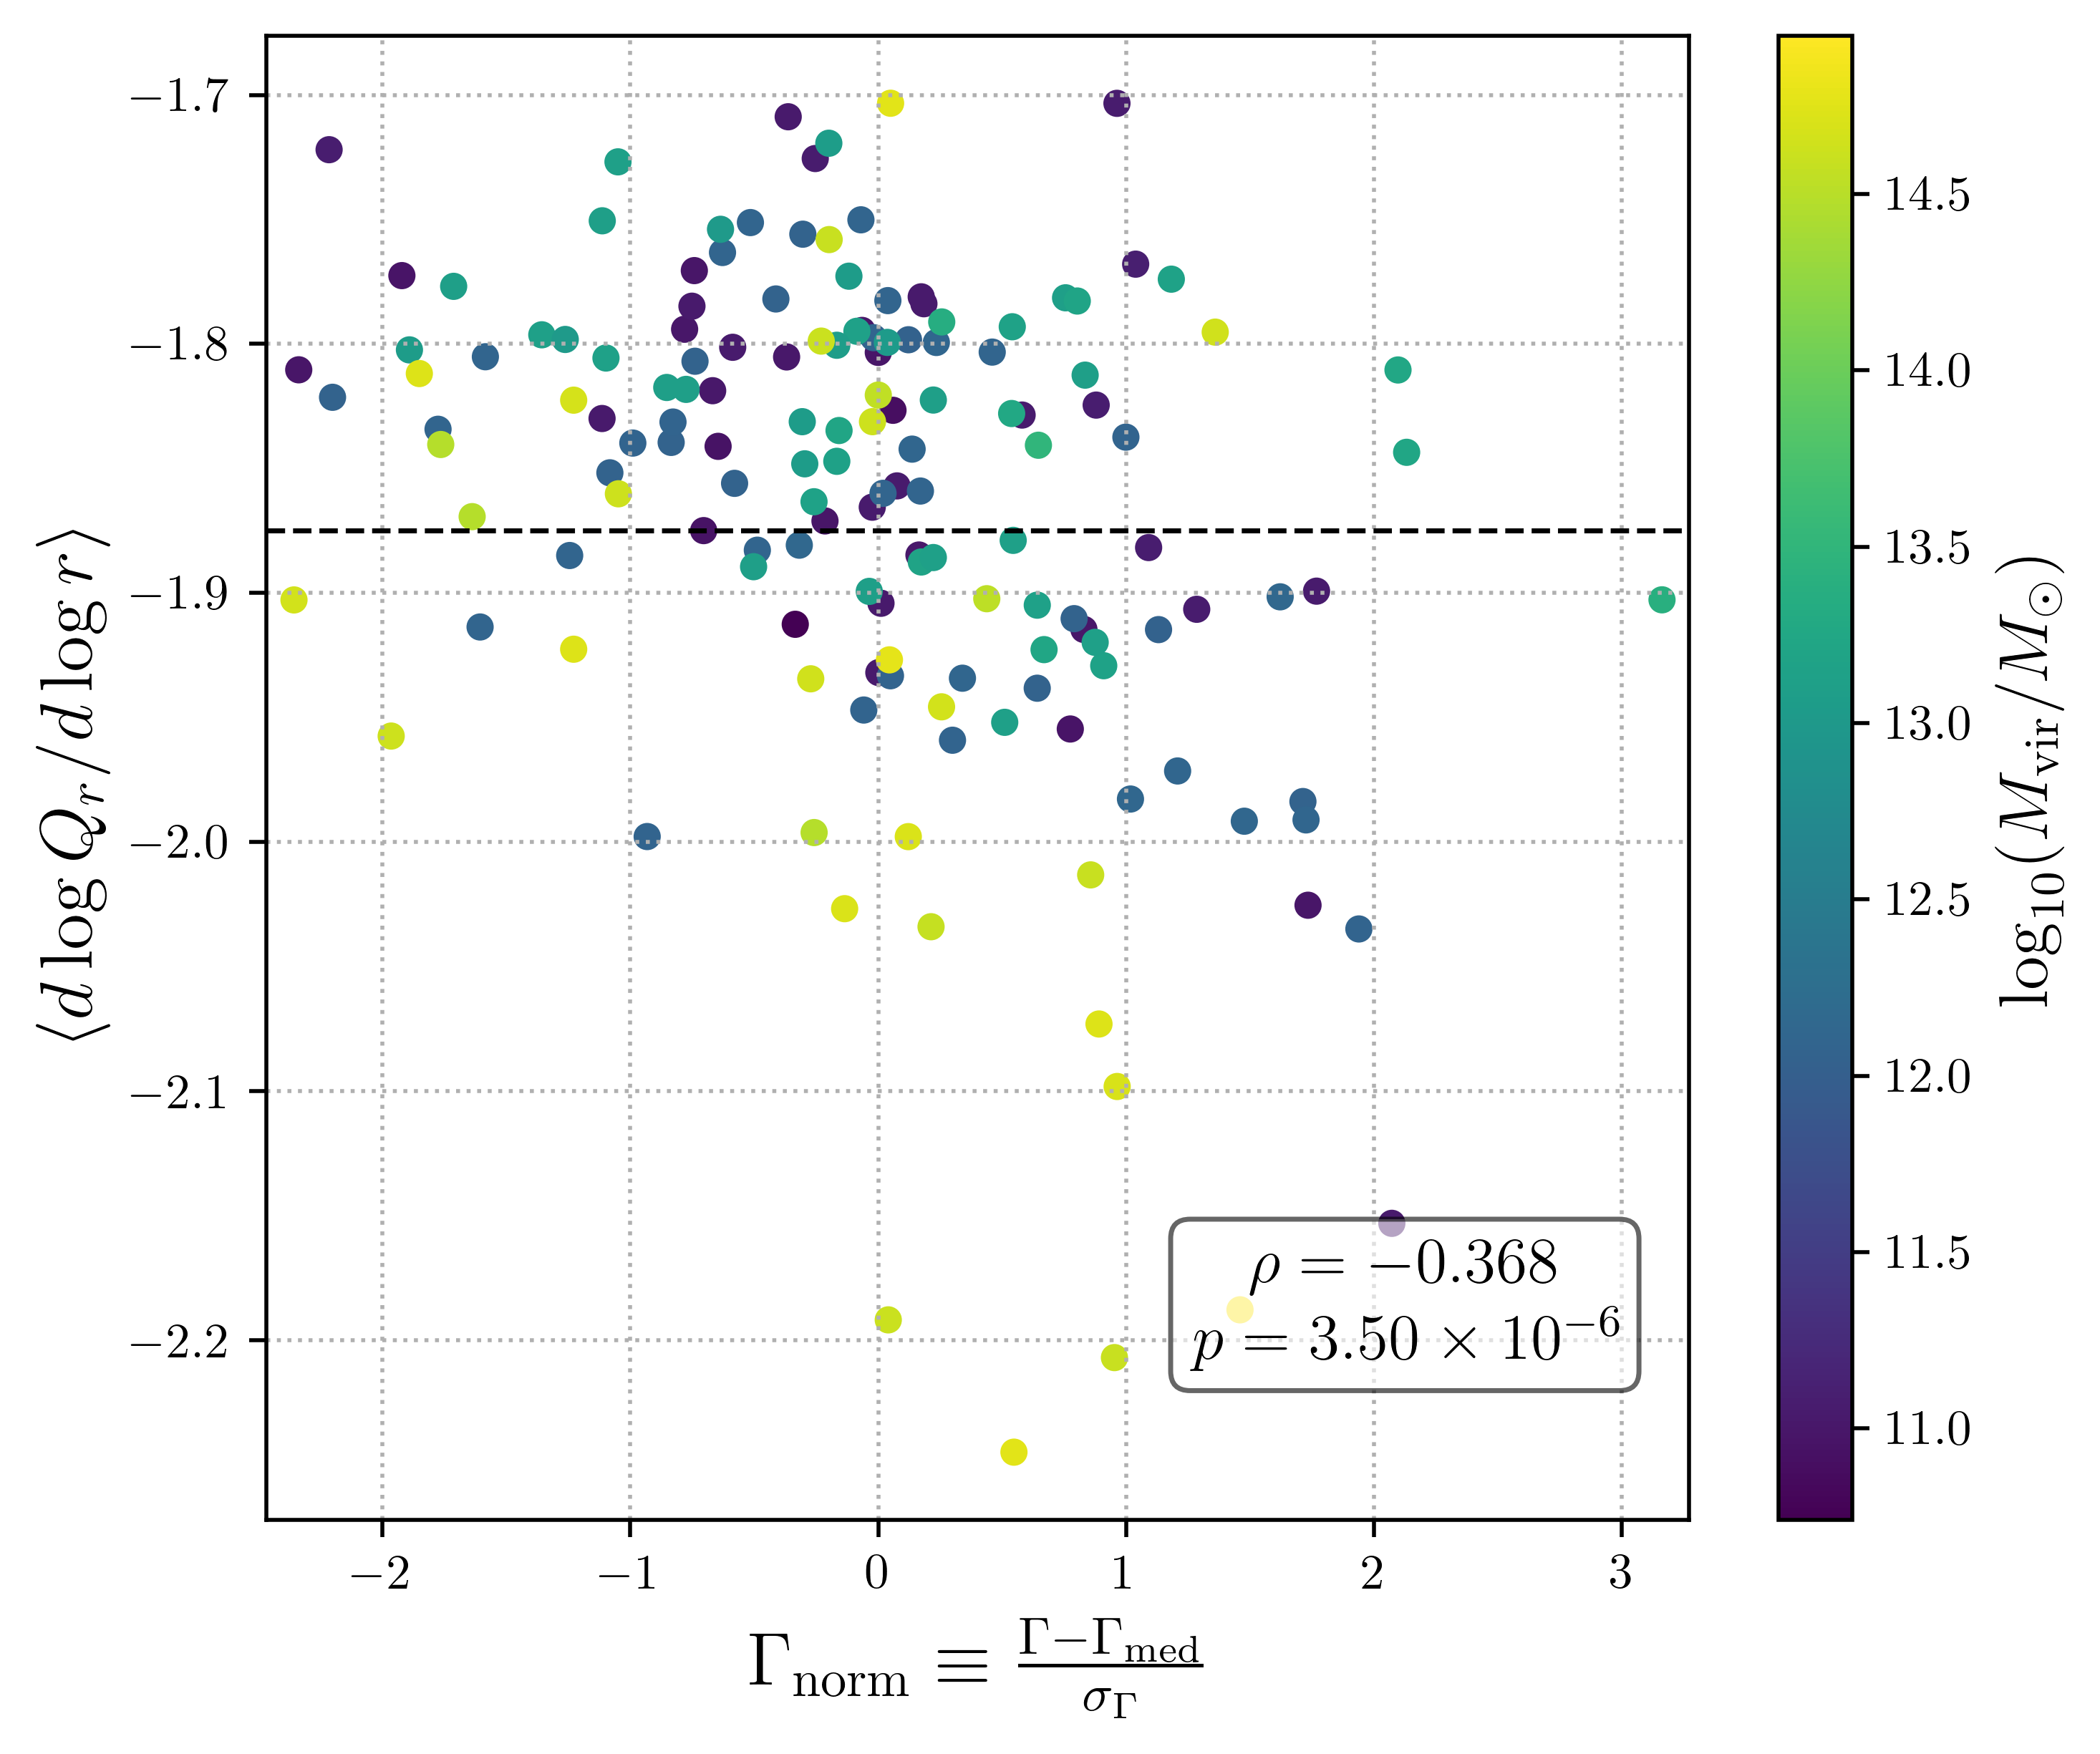

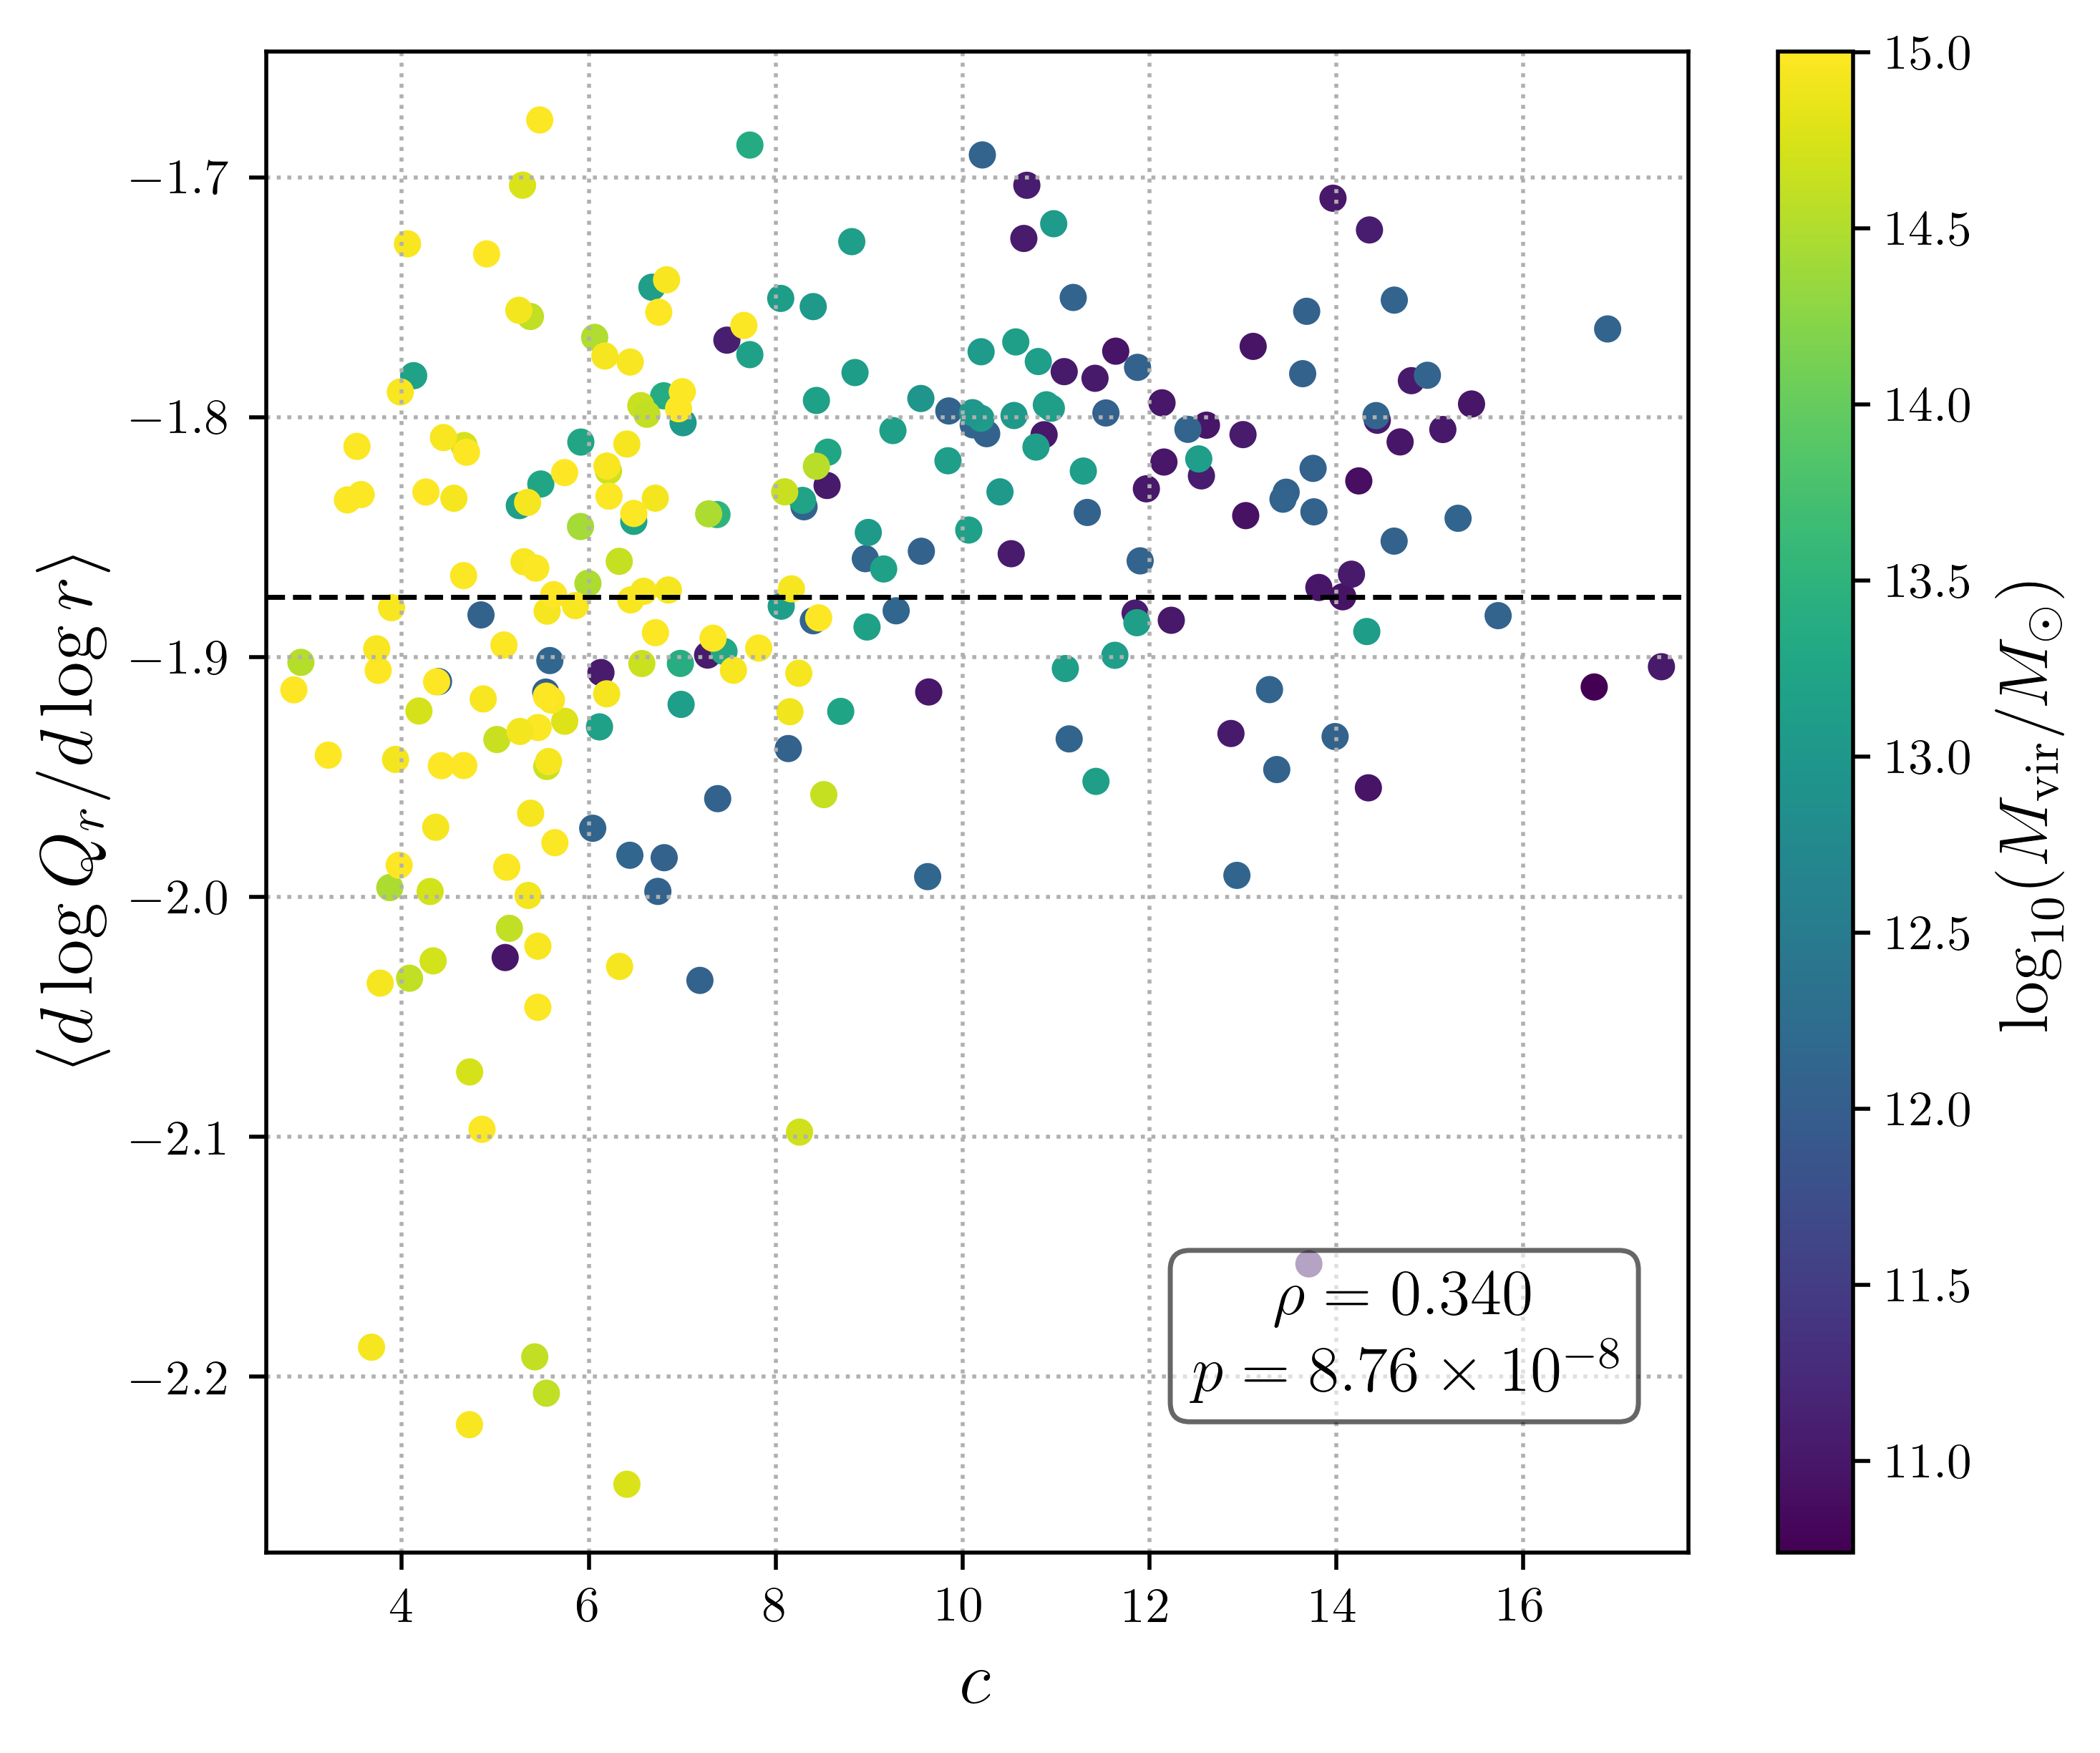

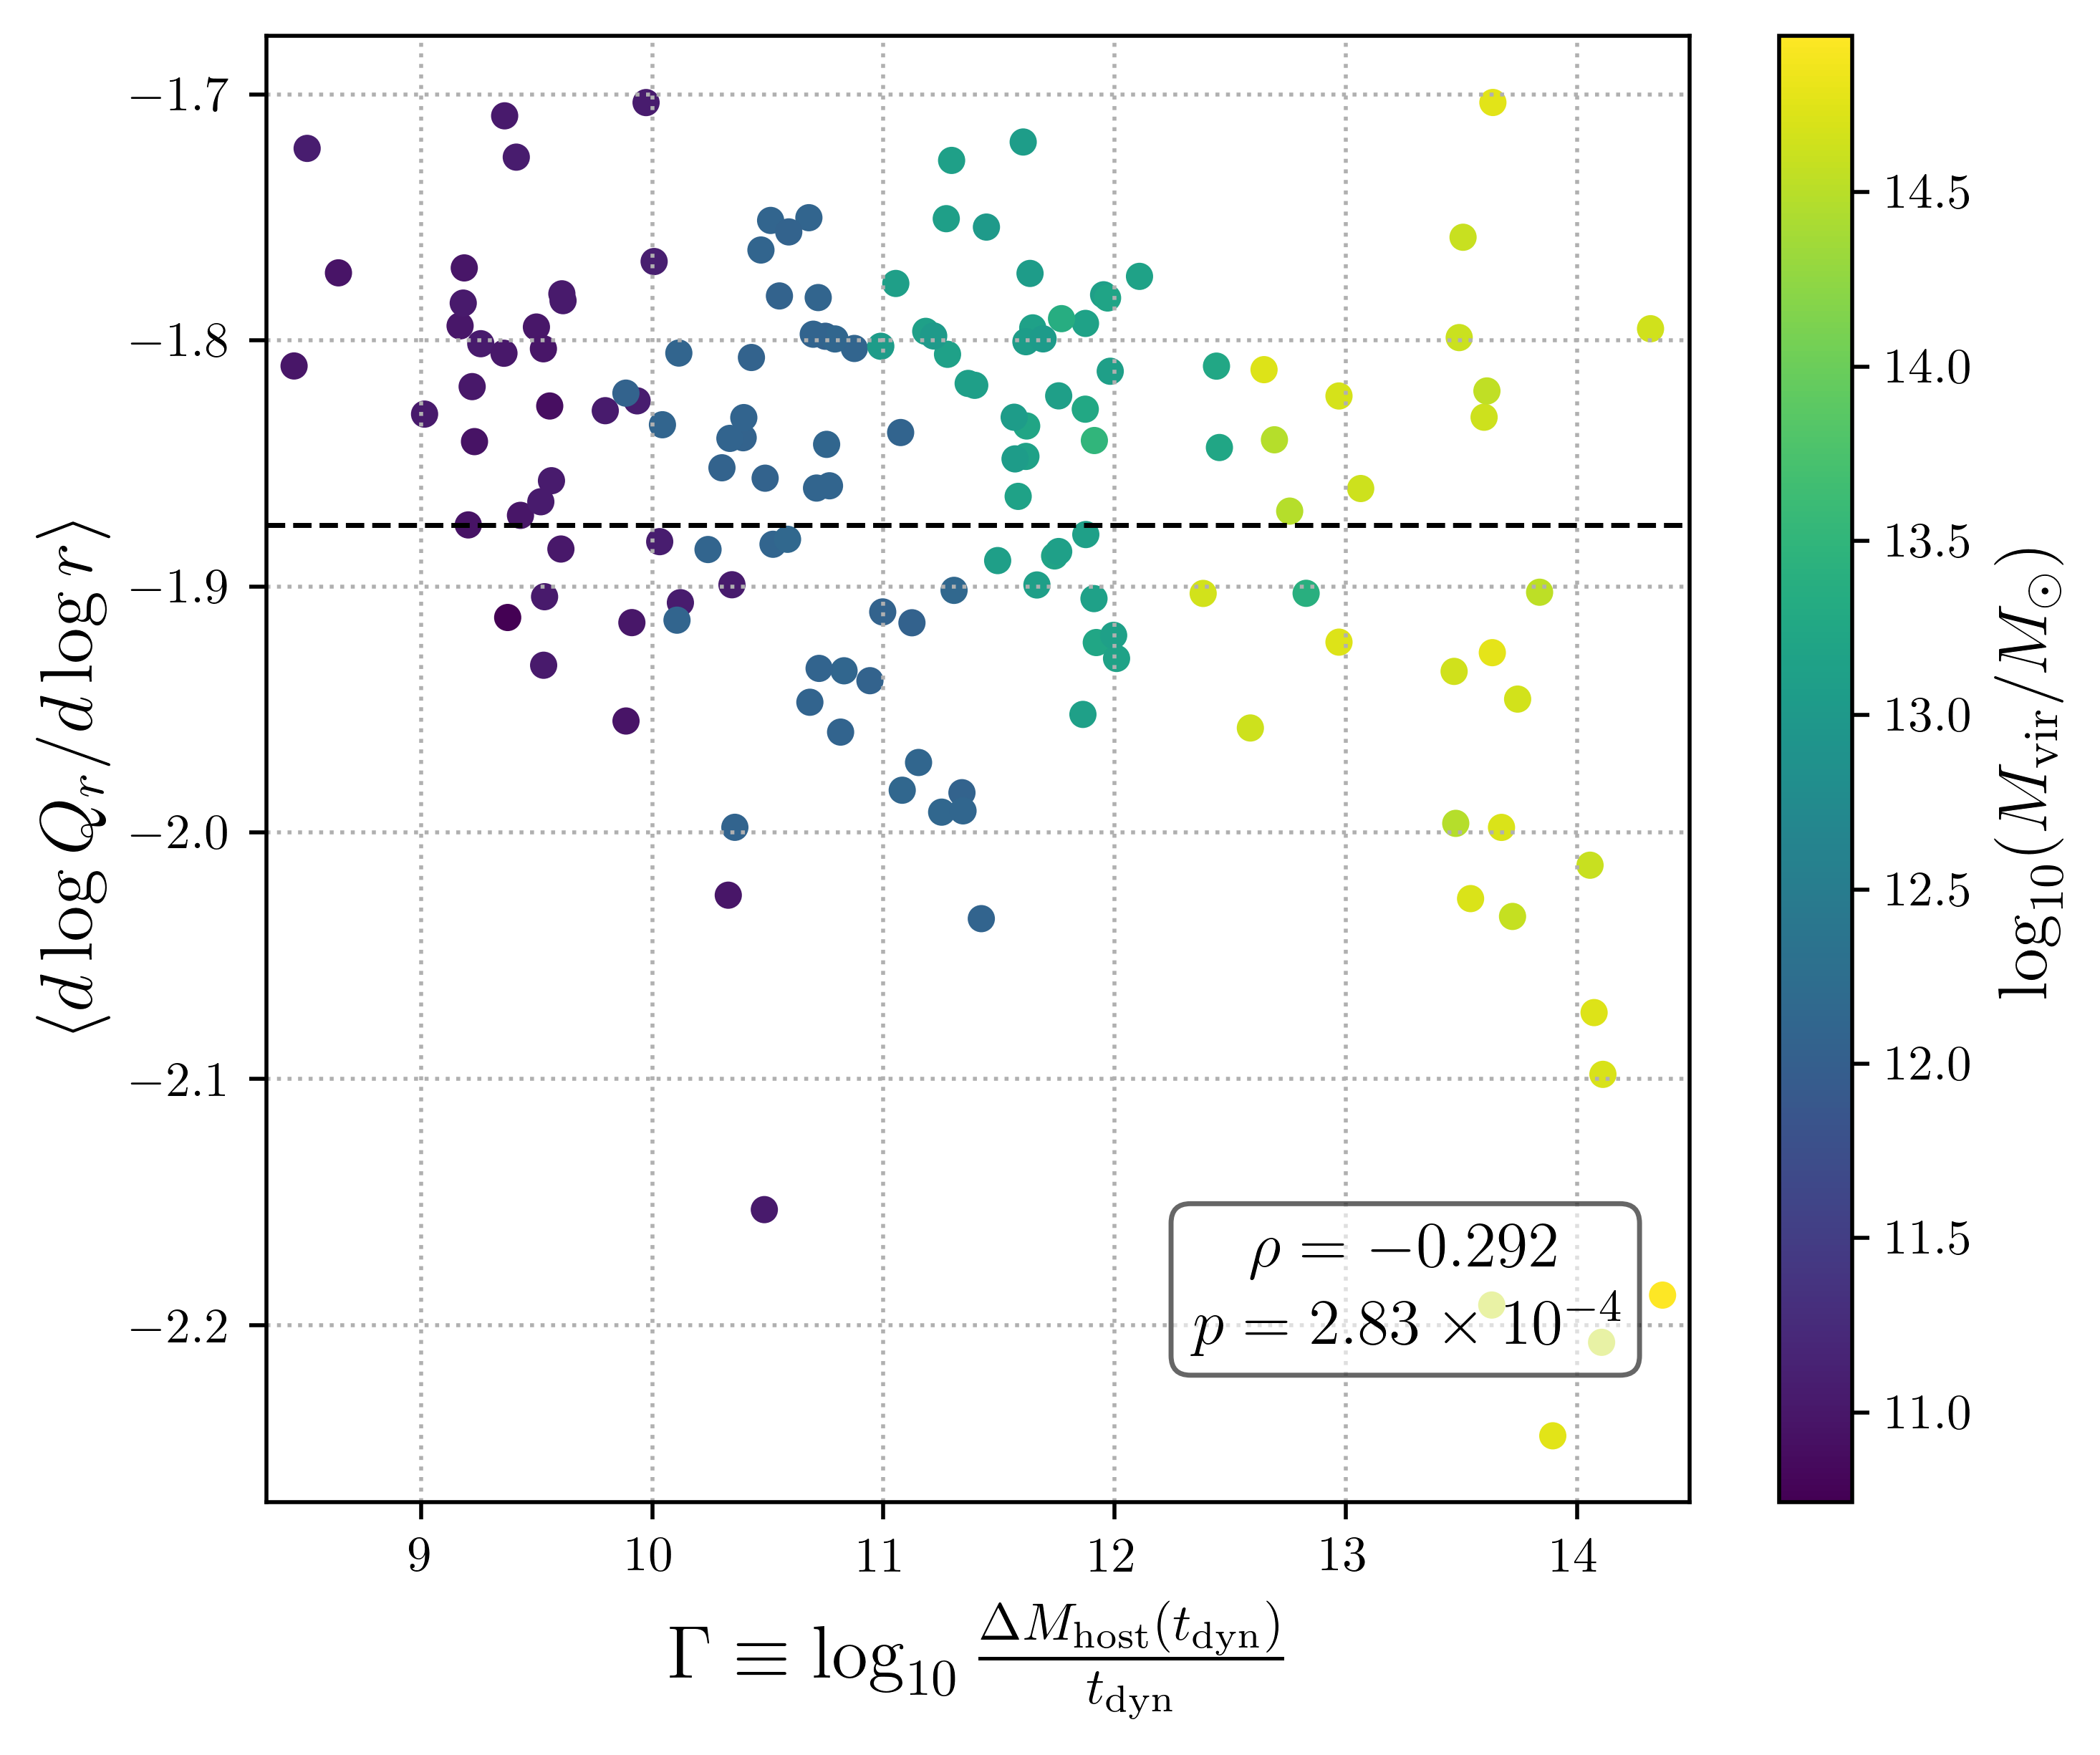

In [40]:
def const_model(r, a):
    """Constant model for curve_fit."""
    return a * np.ones_like(r)

def sci_notation_latex(x, precision=2):
    """
    Return a string like 1.23e-4 → 1.23 \\times 10^{-4}
    """
    fmt = f"{x:.{precision}e}"
    base, exponent = fmt.split("e")
    return rf"{base} \times 10^{{{int(exponent)}}}"

def best_slope_vs_cgamma(base_dir, suite_names,
                          x_var="cvir",
                          slope_column="slope_Q_r",
                          fit_range=(0.01, 1.0)):

    slope_vals, slope_errs, x_vals, mass_vals = [], [], [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")

        df_cvir  = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_concentrations.csv"))
        df_gamma = pd.read_csv(os.path.join(base_dir, "output", suite, "accretion_rates.csv"))
        df_mass  = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_mass.csv"))

        cvir_dict  = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        mass_dict  = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))
        # Raw, coerced gamma series
        g_series = pd.to_numeric(df_gamma["gamma"], errors='coerce')
        mask_g   = np.isfinite(g_series) & (g_series > 0)

        # Filtered dict: halo_index -> gamma (>0)
        gamma_dict = dict(zip(df_gamma.loc[mask_g, "halo_index"], g_series.loc[mask_g]))

        if x_var == "delta_c_norm":
            cm, cstd = df_cvir["cvir"].median(), df_cvir["cvir"].std()
            delta_c_dict = {hid: (c - cm) / cstd
                            for hid, c in zip(df_cvir["halo_id"], df_cvir["cvir"])}

        if x_var == "delta_gamma_norm":
            g_series = pd.to_numeric(df_gamma["gamma"], errors='coerce')
            mask_g   = np.isfinite(g_series) & (g_series > 0)
            lg       = np.log10(g_series.loc[mask_g].to_numpy())
            if lg.size >= 2 and np.nanstd(lg) > 0:
                gm, gstd = np.nanmedian(lg), np.nanstd(lg)
                delta_g_dict = {
                    idx: (np.log10(val) - gm) / gstd
                    for idx, val in zip(df_gamma.loc[mask_g, "halo_index"], g_series.loc[mask_g])
                }
            else:
                delta_g_dict = {}
        for fname in sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv")):
            try:
                hid = int(fname.split("_")[1])
            except Exception:
                continue

            try:
                df = pd.read_csv(os.path.join(slope_dir, fname))
                r  = df["r_scaled"].to_numpy(dtype=float)
                sQ = pd.to_numeric(df[slope_column], errors='coerce').to_numpy(dtype=float)
                mask = (r >= fit_range[0]) & (r <= fit_range[1]) & np.isfinite(sQ)
                if mask.sum() < 3:
                    continue

                popt, pcov = curve_fit(const_model, r[mask], sQ[mask],
                                       p0=np.mean(sQ[mask]),
                                       maxfev=10000)
                slope_fit = popt[0]
                slope_err = np.sqrt(np.diag(pcov))[0] if pcov.size else np.nan

                if   x_var == "cvir":             x = cvir_dict.get(hid,  np.nan)
                elif x_var == "gamma":            x = gamma_dict.get(hid, np.nan)
                elif x_var == "delta_c_norm":     x = delta_c_dict.get(hid, np.nan)
                elif x_var == "delta_gamma_norm": x = delta_g_dict.get(hid, np.nan)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(hid, np.nan)

                if np.isfinite(slope_fit) and np.isfinite(x):
                    slope_vals.append(slope_fit)
                    slope_errs.append(slope_err)
                    x_vals.append(x)
                    mass_vals.append(mass)

            except Exception as e:
                print(f"[Warning] {suite}/{fname}: {e}")

    slope_vals = np.asarray(slope_vals)
    x_vals     = np.asarray(x_vals)
    mass_vals  = np.asarray(mass_vals)

    log_mass = np.log10(mass_vals)
    log_x    = np.log10(x_vals) if x_var == "gamma" else x_vals

    rho, pval = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(6, 5), dpi=500)
    plt.rcParams['text.usetex'] = True

    cmap = plt.cm.Oranges  
    colors = [cmap(0.3), cmap(0.5), cmap(0.7), cmap(0.9)]
    q1, q2, q3 = np.nanpercentile(log_x, [25, 50, 75])
    edges = [(-np.inf, q1), (q1, q2), (q2, q3), (q3, np.inf)]
    ax = plt.gca()

    x_min, x_max = np.nanmin(log_x), np.nanmax(log_x)
    pad = 0.02 * (x_max - x_min) if np.isfinite(x_max - x_min) else 0.0
    ax.set_xlim(x_min - pad, x_max + pad)
    x0, x1 = ax.get_xlim()

    q1, q2, q3 = np.nanpercentile(log_x, [25, 50, 75])
    edges = [(q1, q1), (q1, q2), (q2, q3), (q3, q3)] 

    for i, (lo, hi) in enumerate(edges):
        if i == 0:   # Q1
            lo = x0
            hi = q1
        elif i == 1: # Q2
            lo = q1
            hi = q2
        elif i == 2: # Q3
            lo = q2
            hi = q3
        else:        # Q4
            lo = q3
            hi = x1
        #ax.axvspan(lo, hi, color=colors[i], alpha=0.4, zorder=0)
        
    sc = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=1)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    if x_var == "delta_c_norm":
        plt.xlabel(r"$c_{\mathrm{norm}} \equiv \frac{c-c_{\mathrm{med}}}{\sigma_c}$", fontsize=15)
    if x_var == "delta_gamma_norm":
        plt.xlabel(r"$\Gamma_{\mathrm{norm}} \equiv \frac{\Gamma-\Gamma_{\mathrm{med}}}{\sigma_\Gamma}$", fontsize=15)
    if x_var == "cvir":
        plt.xlabel(r"$c$", fontsize=15)
    if x_var == "gamma":
        plt.xlabel(r"$\Gamma \equiv \log_{10} \frac{\Delta M_{\mathrm{host}}(t_\mathrm{dyn})}{t_\mathrm{dyn}}$", fontsize=15)

    plt.ylabel(r"$\langle d\log Q_r / d\log r\rangle$", fontsize=15)
    txt = rf"$\rho = {rho:.3f}$" + "\n" + rf"$p = {sci_notation_latex(pval)}$"
    plt.gca().text(
        0.8, 0.1, txt, transform=plt.gca().transAxes,
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6), fontsize=13
    )
    plt.grid(True, linestyle=":")

    plt.tight_layout()
    ax.axhline(-1.875, ls="--", color="black", lw=1)
    plt.savefig(os.path.join(out_dir, f"ppsd_slope_vs_{x_var}.pdf"))
    plt.show()

best_slope_vs_cgamma(base_dir, suite_names,
                     x_var="delta_c_norm",
                     slope_column="slope_Q_r",
                     fit_range=(6e-3,1.1))

best_slope_vs_cgamma(base_dir, suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"],
                     x_var="delta_gamma_norm",
                     slope_column="slope_Q_r",
                     fit_range=(6e-3, 1.1))
best_slope_vs_cgamma(base_dir, suite_names,
                     x_var="cvir",
                     slope_column="slope_Q_r",
                     fit_range=(6e-3,1.1))

best_slope_vs_cgamma(base_dir, suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"],
                     x_var="gamma",
                     slope_column="slope_Q_r",
                     fit_range=(6e-3, 1.1))

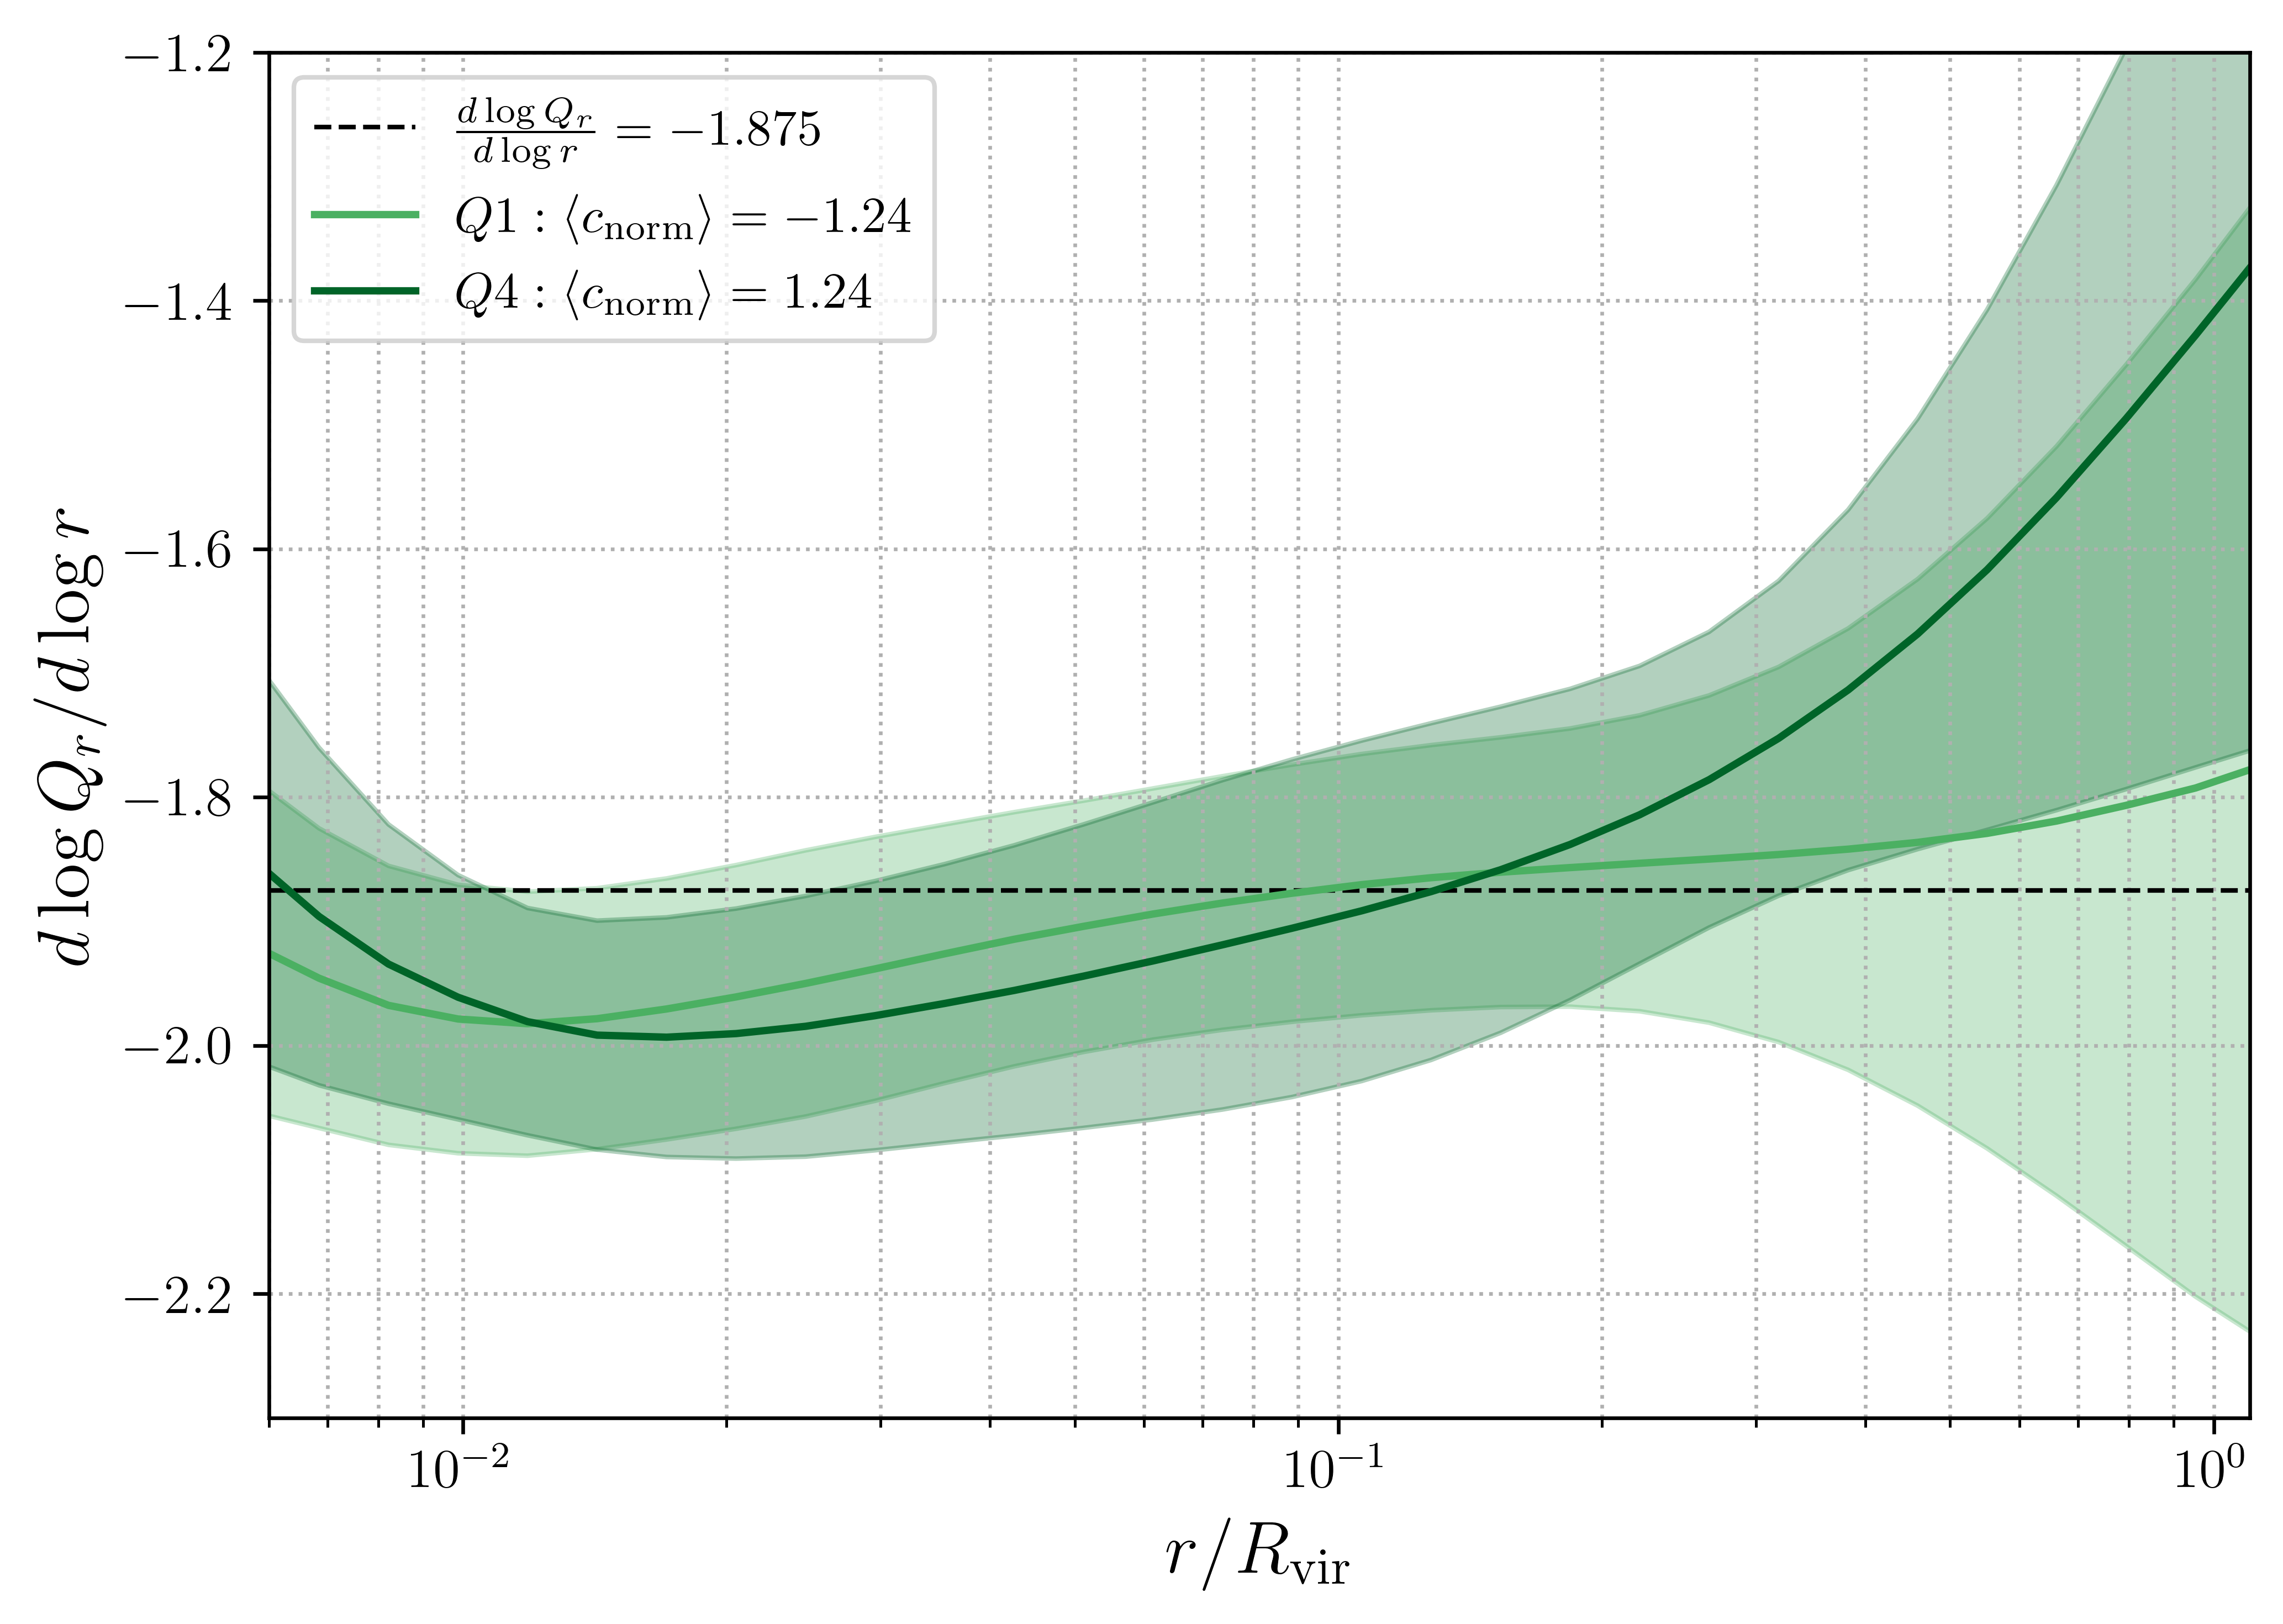

In [46]:
def plot_ppsd_slope_split_by_quartiles_norm_vs_r_per_suite():
    import numpy as np
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    # -------------------------
    # Aggregators across suites
    # -------------------------
    # For c_norm
    c_quart_slopes = {0: [], 1: [], 2: [], 3: []}
    c_quart_vals   = {0: [], 1: [], 2: [], 3: []}  # store per-halo c_norm to report mean in label

    # For gamma_norm
    g_quart_slopes = {0: [], 1: [], 2: [], 3: []}
    g_quart_vals   = {0: [], 1: [], 2: [], 3: []}  # store per-halo gamma_norm to report mean in label

    r_ref = None
    n_r_ref = None

    # -------------------------
    # Loop over suites
    # -------------------------
    for suite in suite_names:
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        if not os.path.isdir(dir_r):
            continue

        # --- read c and gamma tables (suite-scope statistics) ---
        c_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        g_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        if not os.path.isfile(c_path):
            continue

        dfc = pd.read_csv(c_path)
        dfc["halo_id_int"] = pd.to_numeric(dfc["halo_id"], errors="coerce").astype("Int64")
        dfc["cvir"] = pd.to_numeric(dfc["cvir"], errors="coerce")

        # Concentration suite-level normalization
        c_valid = dfc["cvir"].to_numpy(dtype=float)
        c_valid = c_valid[np.isfinite(c_valid)]
        if c_valid.size < 4 or np.nanstd(c_valid) == 0:
            # not enough spread or too few to quartile
            c_quart_edges = None
        else:
            c_med = np.nanmedian(c_valid)
            c_std = np.nanstd(c_valid)
            dfc["c_norm"] = (dfc["cvir"] - c_med) / c_std
            c_quart_edges = np.nanpercentile(dfc["c_norm"], [25, 50, 75])

        # Gamma table may be missing or sparse
        if os.path.isfile(g_path):
            dfg = pd.read_csv(g_path)
            dfg["halo_index_int"] = pd.to_numeric(dfg["halo_index"], errors="coerce").astype("Int64")
            dfg["gamma"] = pd.to_numeric(dfg["gamma"], errors="coerce")
            # Suite-level gamma normalization (log10, gamma>0)
            mask_pos = (dfg["gamma"] > 0) & dfg["gamma"].notna()
            if mask_pos.sum() >= 4:
                lg = np.log10(dfg.loc[mask_pos, "gamma"].to_numpy(dtype=float))
                gm = np.nanmedian(lg)
                gs = np.nanstd(lg)
                if np.isfinite(gs) and gs > 0:
                    dfg.loc[mask_pos, "g_norm"] = (np.log10(dfg.loc[mask_pos, "gamma"]) - gm) / gs
                    g_quart_edges = np.nanpercentile(dfg.loc[mask_pos, "g_norm"], [25, 50, 75])
                else:
                    g_quart_edges = None
            else:
                g_quart_edges = None
        else:
            dfg = None
            g_quart_edges = None

        # Build quick lookup for this suite
        c_norm_map = {}
        if c_quart_edges is not None:
            for hid, c_norm in zip(dfc["halo_id_int"], dfc["c_norm"]):
                if pd.notna(hid) and np.isfinite(c_norm):
                    c_norm_map[int(hid)] = float(c_norm)

        g_norm_map = {}
        if dfg is not None and g_quart_edges is not None and "g_norm" in dfg.columns:
            for hid, g_norm in zip(dfg["halo_index_int"], dfg["g_norm"]):
                if pd.notna(hid) and np.isfinite(g_norm):
                    g_norm_map[int(hid)] = float(g_norm)

        # Helper: assign quartile index given edges
        def assign_quartile(val, edges):
            # edges: [q25, q50, q75]
            q1, q2, q3 = edges
            if val <= q1:
                return 0
            elif val <= q2:
                return 1
            elif val <= q3:
                return 2
            else:
                return 3

        # --- iterate halos in this suite, read slope curves, and assign to quartiles ---
        for fn in sorted(os.listdir(dir_r)):
            if not fn.endswith(".csv"):
                continue
            # parse halo index from filename like "halo_012_profile.csv"
            try:
                idx = int(fn.split("_")[1])
            except Exception:
                continue

            full_path = os.path.join(dir_r, fn)
            df = pd.read_csv(full_path)
            sr = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy()
            if r_ref is None:
                r_ref = df["r_scaled"].to_numpy()
                n_r_ref = r_ref.size
            else:
                # optional: skip curves with mismatched radial grid length
                if sr.size != n_r_ref:
                    continue

            # c_norm quartiles (per-suite)
            if c_quart_edges is not None and (idx in c_norm_map):
                cn = c_norm_map[idx]
                q_idx = assign_quartile(cn, c_quart_edges)
                c_quart_slopes[q_idx].append(sr)
                c_quart_vals[q_idx].append(cn)

            # g_norm quartiles (per-suite)
            if g_quart_edges is not None and (idx in g_norm_map):
                gn = g_norm_map[idx]
                q_idx = assign_quartile(gn, g_quart_edges)
                g_quart_slopes[q_idx].append(sr)
                g_quart_vals[q_idx].append(gn)

    if r_ref is None:
        print("[Warning] No valid slope data found.")
        return

    def plot_quartiles(x, quart_slopes, quart_vals, fname, var_name):
        plt.rcParams["text.usetex"] = True
        fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

        ax.set_xscale("log")
        ax.grid(which="both", linestyle=":")
        ax.axhline(-1.875, ls="--", color="black", lw=1, label=r"$\frac{d\log Q_r}{d\log r}=-1.875$")
        ax.set_xlim(6e-3, 1.1)
        ax.set_ylim(-2.3, -1.2)
        ax.set_xlabel(r"$r / R_{\rm vir}$", fontsize=16)
        ax.set_ylabel(r"$d\log Q_r / d\log r$", fontsize=16)
        ax.tick_params(axis="both", labelsize=12)

        cmap = plt.cm.Greens
        colors = [cmap(0.6), cmap(0.9)]   # only use lightest and darkest
        labels = ["Q1", "Q4"]

        for i, q in enumerate([0, 3]):   # only Q1 and Q4
            Ys = quart_slopes[q]
            vs = quart_vals[q]
            if len(Ys) == 0:
                ax.plot([], [], label=f"{labels[i]} (N=0)")
                continue

            Y = np.vstack(Ys)
            mu = np.nanmean(Y, axis=0)
            sd = np.nanstd(Y, axis=0)
            vmean = float(np.nanmean(vs)) if len(vs) else np.nan

            ax.fill_between(x, mu - sd, mu + sd, alpha=0.3, color=colors[i])
            ax.plot(x, mu, lw=1.6, color=colors[i],
                    label=fr"${labels[i]}: \langle {var_name} \rangle= {vmean:.2f}$")

        ax.legend(loc='upper left', fontsize=11)
        plt.tight_layout()
        out_path = os.path.join(out_dir, fname)
        plt.savefig(out_path)
        plt.show()
        plt.close(fig)
        
    plot_quartiles(
        r_ref, c_quart_slopes, c_quart_vals,
        fname="ppsd_slope_r_split_cnorm_quartiles.pdf",
        var_name=r"c_{\mathrm{norm}}"
    )

plot_ppsd_slope_split_by_quartiles_norm_vs_r_per_suite()

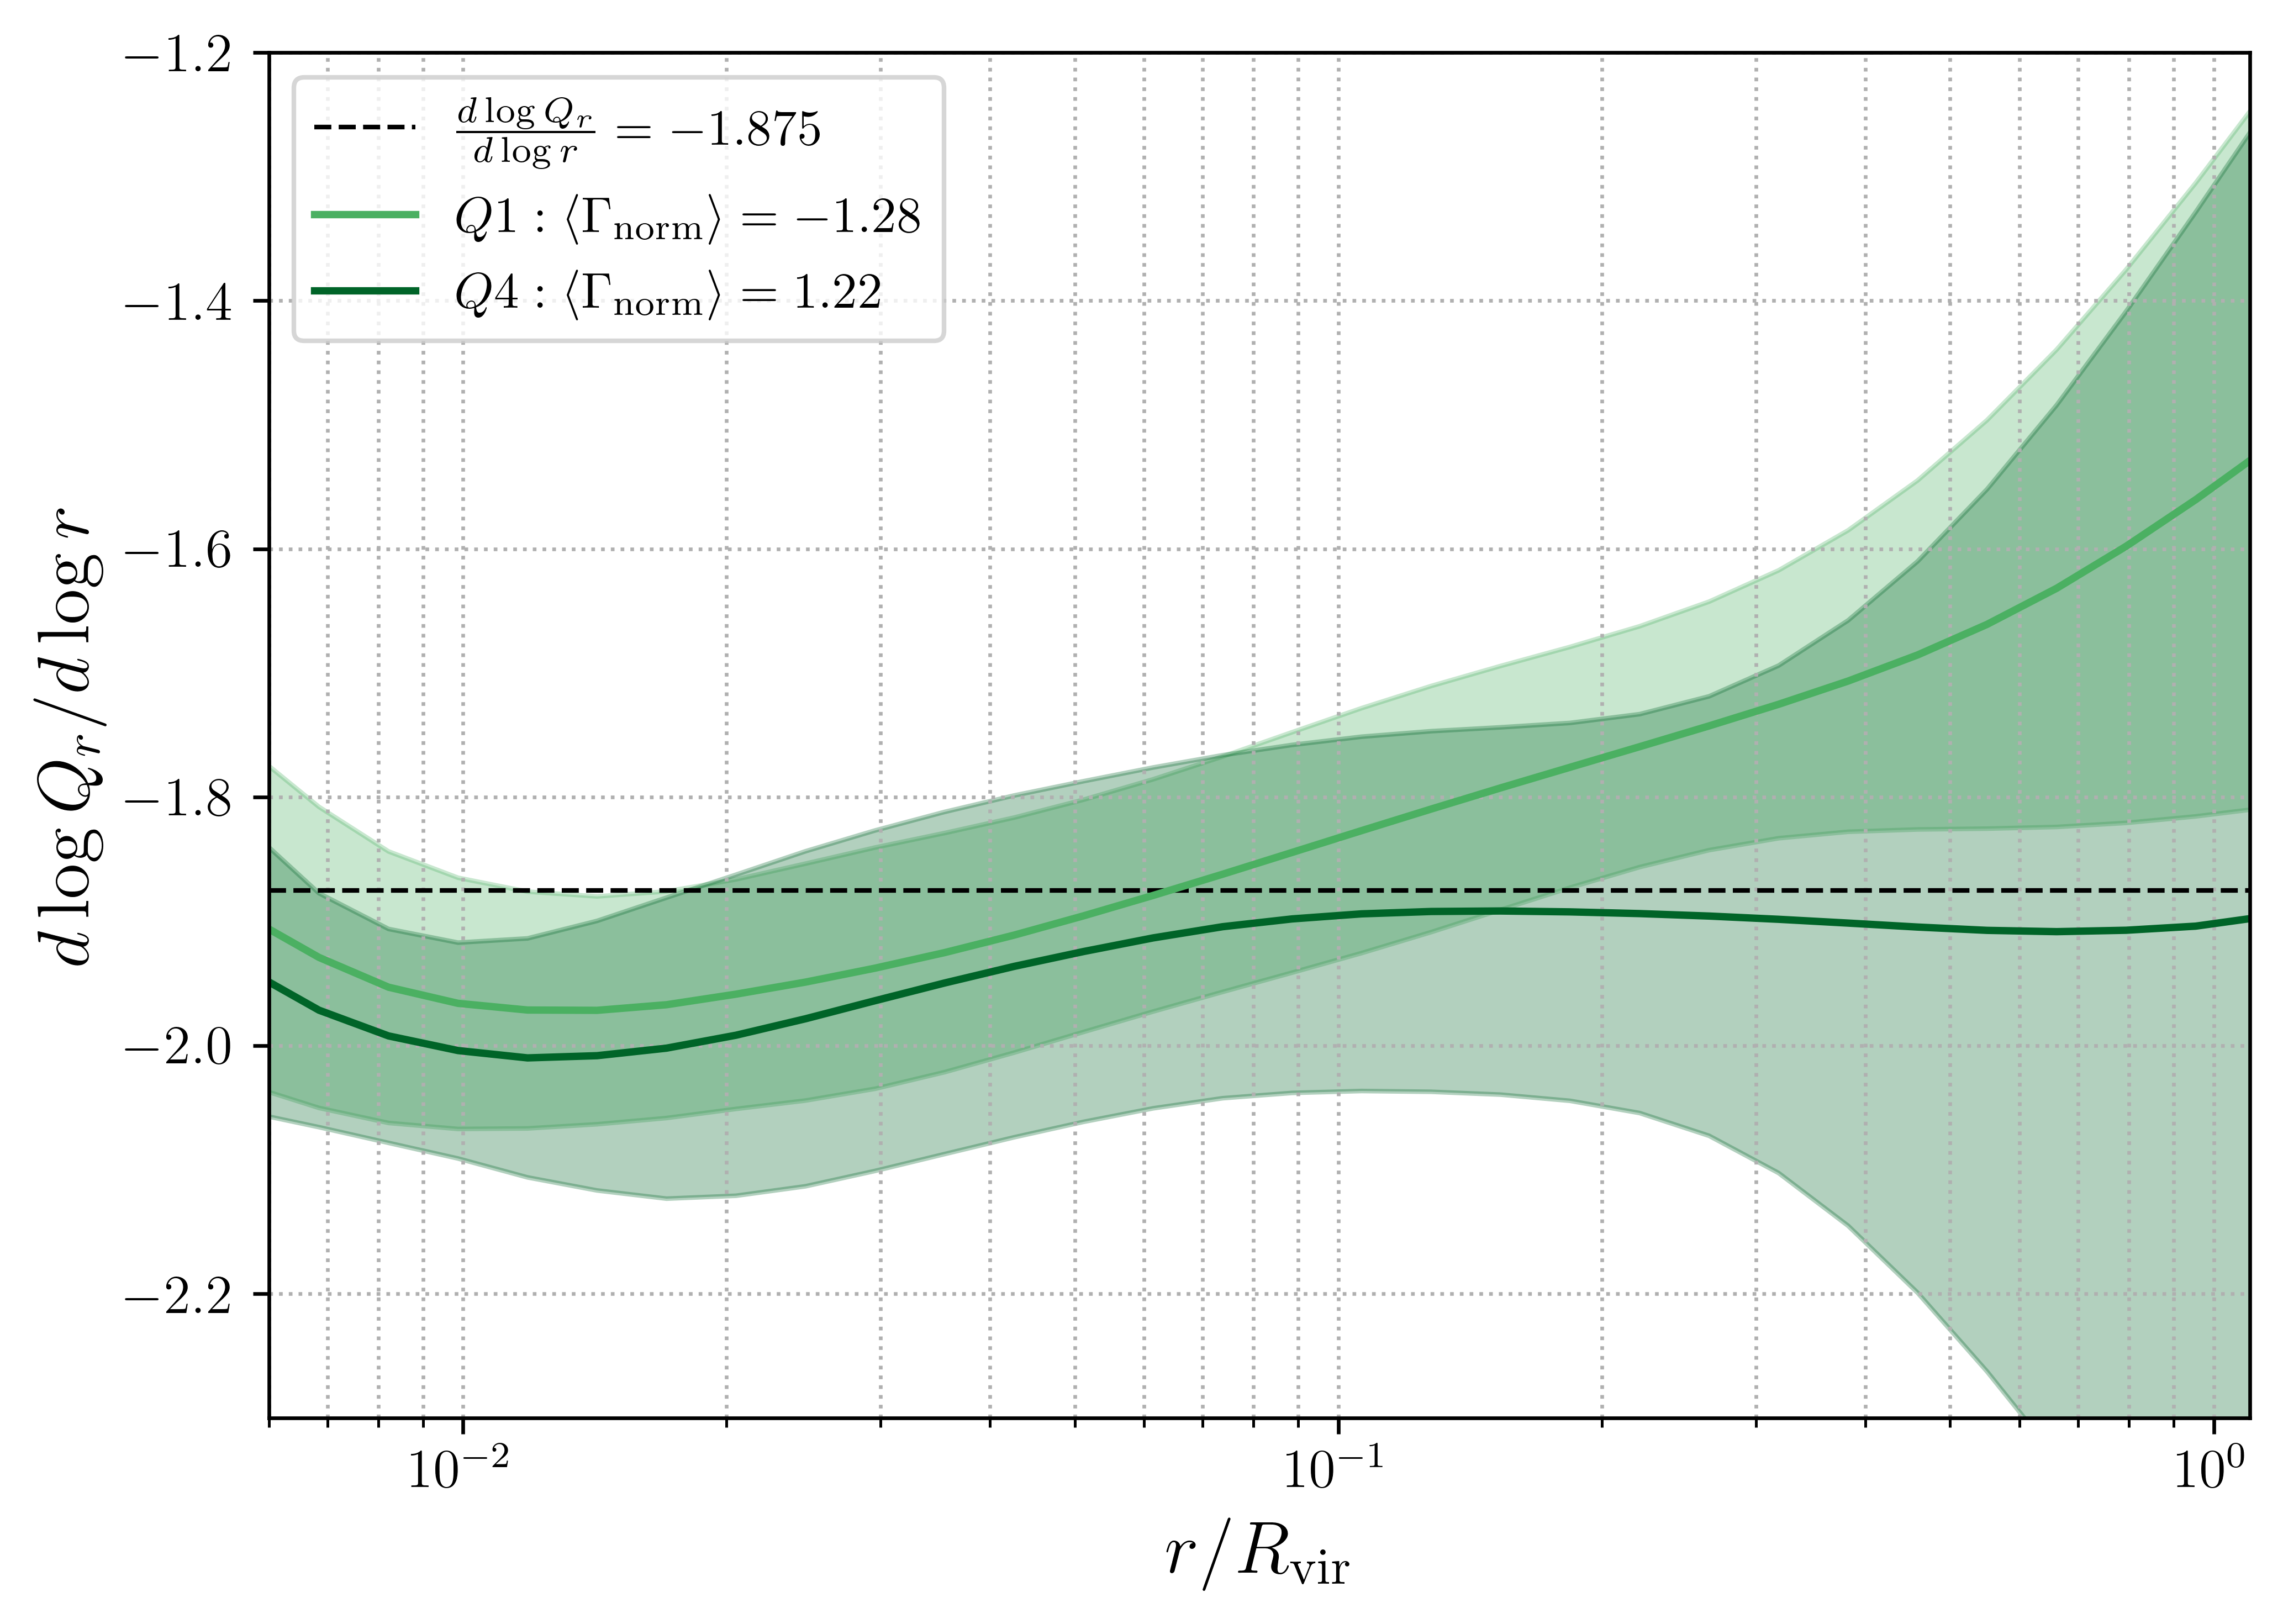

In [47]:
def plot_ppsd_slope_split_by_quartiles_norm_vs_r_per_suite():
    """
    Per-suite normalization & quartile binning, then merge same-quantile halos across suites.

    For each suite:
      - c_norm = (c - median(c)) / std(c)
      - g_norm = (log10(gamma>0) - median(log10(gamma>0))) / std(log10(gamma>0))
      - Compute quartile edges (25/50/75%) within THIS suite
      - Assign each halo to Q1..Q4 for c_norm and for g_norm

    After that, aggregate the same quartiles across suites and plot:
      1) c_norm quartiles: mean ± std of slope_Q_r vs r (labels show N and mean c_norm per quartile)
      2) gamma_norm quartiles: mean ± std of slope_Q_r vs r (labels show N and mean gamma_norm per quartile)
    """
    import numpy as np
    import pandas as pd
    import os
    import matplotlib.pyplot as plt

    # -------------------------
    # Aggregators across suites
    # -------------------------
    # For c_norm
    c_quart_slopes = {0: [], 1: [], 2: [], 3: []}
    c_quart_vals   = {0: [], 1: [], 2: [], 3: []}  # store per-halo c_norm to report mean in label

    # For gamma_norm
    g_quart_slopes = {0: [], 1: [], 2: [], 3: []}
    g_quart_vals   = {0: [], 1: [], 2: [], 3: []}  # store per-halo gamma_norm to report mean in label

    r_ref = None
    n_r_ref = None

    # -------------------------
    # Loop over suites
    # -------------------------
    for suite in ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"]:
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        if not os.path.isdir(dir_r):
            continue

        # --- read c and gamma tables (suite-scope statistics) ---
        c_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        g_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        if not os.path.isfile(c_path):
            continue

        dfc = pd.read_csv(c_path)
        dfc["halo_id_int"] = pd.to_numeric(dfc["halo_id"], errors="coerce").astype("Int64")
        dfc["cvir"] = pd.to_numeric(dfc["cvir"], errors="coerce")

        # Concentration suite-level normalization
        c_valid = dfc["cvir"].to_numpy(dtype=float)
        c_valid = c_valid[np.isfinite(c_valid)]
        if c_valid.size < 4 or np.nanstd(c_valid) == 0:
            # not enough spread or too few to quartile
            c_quart_edges = None
        else:
            c_med = np.nanmedian(c_valid)
            c_std = np.nanstd(c_valid)
            dfc["c_norm"] = (dfc["cvir"] - c_med) / c_std
            c_quart_edges = np.nanpercentile(dfc["c_norm"], [25, 50, 75])

        # Gamma table may be missing or sparse
        if os.path.isfile(g_path):
            dfg = pd.read_csv(g_path)
            dfg["halo_index_int"] = pd.to_numeric(dfg["halo_index"], errors="coerce").astype("Int64")
            dfg["gamma"] = pd.to_numeric(dfg["gamma"], errors="coerce")
            # Suite-level gamma normalization (log10, gamma>0)
            mask_pos = (dfg["gamma"] > 0) & dfg["gamma"].notna()
            if mask_pos.sum() >= 4:
                lg = np.log10(dfg.loc[mask_pos, "gamma"].to_numpy(dtype=float))
                gm = np.nanmedian(lg)
                gs = np.nanstd(lg)
                if np.isfinite(gs) and gs > 0:
                    dfg.loc[mask_pos, "g_norm"] = (np.log10(dfg.loc[mask_pos, "gamma"]) - gm) / gs
                    g_quart_edges = np.nanpercentile(dfg.loc[mask_pos, "g_norm"], [25, 50, 75])
                else:
                    g_quart_edges = None
            else:
                g_quart_edges = None
        else:
            dfg = None
            g_quart_edges = None

        # Build quick lookup for this suite
        c_norm_map = {}
        if c_quart_edges is not None:
            for hid, c_norm in zip(dfc["halo_id_int"], dfc["c_norm"]):
                if pd.notna(hid) and np.isfinite(c_norm):
                    c_norm_map[int(hid)] = float(c_norm)

        g_norm_map = {}
        if dfg is not None and g_quart_edges is not None and "g_norm" in dfg.columns:
            for hid, g_norm in zip(dfg["halo_index_int"], dfg["g_norm"]):
                if pd.notna(hid) and np.isfinite(g_norm):
                    g_norm_map[int(hid)] = float(g_norm)

        # Helper: assign quartile index given edges
        def assign_quartile(val, edges):
            # edges: [q25, q50, q75]
            q1, q2, q3 = edges
            if val <= q1:
                return 0
            elif val <= q2:
                return 1
            elif val <= q3:
                return 2
            else:
                return 3

        # --- iterate halos in this suite, read slope curves, and assign to quartiles ---
        for fn in sorted(os.listdir(dir_r)):
            if not fn.endswith(".csv"):
                continue
            # parse halo index from filename like "halo_012_profile.csv"
            try:
                idx = int(fn.split("_")[1])
            except Exception:
                continue

            full_path = os.path.join(dir_r, fn)
            df = pd.read_csv(full_path)
            sr = pd.to_numeric(df["slope_Q_r"], errors="coerce").to_numpy()
            if r_ref is None:
                r_ref = df["r_scaled"].to_numpy()
                n_r_ref = r_ref.size
            else:
                # optional: skip curves with mismatched radial grid length
                if sr.size != n_r_ref:
                    continue

            # c_norm quartiles (per-suite)
            if c_quart_edges is not None and (idx in c_norm_map):
                cn = c_norm_map[idx]
                q_idx = assign_quartile(cn, c_quart_edges)
                c_quart_slopes[q_idx].append(sr)
                c_quart_vals[q_idx].append(cn)

            # g_norm quartiles (per-suite)
            if g_quart_edges is not None and (idx in g_norm_map):
                gn = g_norm_map[idx]
                q_idx = assign_quartile(gn, g_quart_edges)
                g_quart_slopes[q_idx].append(sr)
                g_quart_vals[q_idx].append(gn)

    if r_ref is None:
        print("[Warning] No valid slope data found.")
        return

    def plot_quartiles(x, quart_slopes, quart_vals, fname, var_name):
        plt.rcParams["text.usetex"] = True
        fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

        ax.set_xscale("log")
        ax.grid(which="both", linestyle=":")
        ax.axhline(-1.875, ls="--", color="black", lw=1, label=r"$\frac{d\log Q_r}{d\log r}=-1.875$")
        ax.set_xlim(6e-3, 1.1)
        ax.set_ylim(-2.3, -1.2)
        ax.set_xlabel(r"$r / R_{\rm vir}$", fontsize=16)
        ax.set_ylabel(r"$d\log Q_r / d\log r$", fontsize=16)
        ax.tick_params(axis="both", labelsize=12)

        cmap = plt.cm.Greens
        colors = [cmap(0.6), cmap(0.9)]   # only use lightest and darkest
        labels = ["Q1", "Q4"]

        for i, q in enumerate([0, 3]):   # only Q1 and Q4
            Ys = quart_slopes[q]
            vs = quart_vals[q]
            if len(Ys) == 0:
                ax.plot([], [], label=f"{labels[i]} (N=0)")
                continue

            Y = np.vstack(Ys)
            mu = np.nanmean(Y, axis=0)
            sd = np.nanstd(Y, axis=0)
            vmean = float(np.nanmean(vs)) if len(vs) else np.nan

            ax.fill_between(x, mu - sd, mu + sd, alpha=0.3, color=colors[i])
            ax.plot(x, mu, lw=1.6, color=colors[i],
                    label=rf"${labels[i]}: \langle {var_name} \rangle= {vmean:.2f}$")

        ax.legend(loc='upper left', fontsize=11)
        plt.tight_layout()
        out_path = os.path.join(out_dir, fname)
        plt.savefig(out_path)
        plt.show()
        plt.close(fig)
        
    plot_quartiles(
        r_ref, g_quart_slopes, g_quart_vals,
        fname="ppsd_slope_r_split_gammanorm_quartiles.pdf",
        var_name=r"\Gamma_{\mathrm{norm}}"
    )

plot_ppsd_slope_split_by_quartiles_norm_vs_r_per_suite()